In [1]:
from ESDIRK23 import ESDIRK23_solver
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import time
from matplotlib.gridspec import GridSpec
import numba

In [2]:
plt.style.use('seaborn-v0_8-whitegrid')  
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 13
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['legend.fontsize'] = 13

In [3]:
t_range = np.array((0.0, 0.5))
h_size = np.array((1e-12 ,1e-4))
x0 = np.array((2.0, 0.5, 300.0))
argv = np.array([
    np.exp(18),  # k03
    15000.0,        # Ea_R
    -560.0,        # deltaHr
    1.0,           # rho
    4.186,         # cP
    0.1,           # v = F/A 
    0.05,           # D_A
    0.05,           # D_B
    0.02,           # D_T
    210,            # N (number of grid points)
    1e-3,         # dz = L/(N+1)
    1.0,           # Left boundary CA
    1.0,           # Left boundary CB
    250.0,          # Left boundary T
    0.0,           # right CA
    2.0,           # right CB
    150.0          # right T

], dtype=np.float64)

reps = 1e-8
aeps = 1e-10
num_var = np.size(x0)
model = 5 # 1 is van der pol model
MAX_STEPS = int(1500000)
t_history, x_history, t_adaptive_size, t_adaptive = ESDIRK23_solver(x0, argv, t_range, h_size, reps, aeps, model, MAX_STEPS)


step size number is: 273818


In [4]:
x_history_1 = np.zeros((t_history.shape[0], int(argv[9] / 3)))
x_history_2 = np.zeros((t_history.shape[0], int(argv[9] / 3)))
x_history_3 = np.zeros((t_history.shape[0], int(argv[9] / 3)))

In [5]:
N = int(argv[9])  
num_steps = t_history.shape[0]  

x_history_1 = np.zeros((num_steps, N))  # CA
x_history_2 = np.zeros((num_steps, N))  # CB
x_history_3 = np.zeros((num_steps, N))  # T

@numba.jit(nopython = True, cache = True)
def shape_arr(x_history_1, x_history_2, x_history_3, x_history, N, num_steps):
    for i in range(num_steps):
        start_idx = i * N * 3
        for j in range(N):
            idx = start_idx + j * 3
            x_history_1[i, j] = x_history[idx]      # CA
            x_history_2[i, j] = x_history[idx + 1]  # CB
            x_history_3[i, j] = x_history[idx + 2]  # T
    return x_history_1, x_history_2, x_history_3

x_history_1, x_history_2, x_history_3 = shape_arr(x_history_1, x_history_2, x_history_3, x_history, N, num_steps)

In [6]:
@numba.jit(nopython = True, cache = True)
def shape_arr(x_history_1, x_history_2,x_history_3, x_history, t_history):
    N = int(argv[9])  
    num_steps = t_history.shape[0]  

    for i in range(num_steps):
        start_idx = i * N * 3
        for j in range(N):
            idx = start_idx + j * 3
            x_history_1[i, j] = x_history[idx]      # CA
            x_history_2[i, j] = x_history[idx + 1]  # CB
            x_history_3[i, j] = x_history[idx + 2]  # T
    return x_history_1, x_history_2, x_history_3

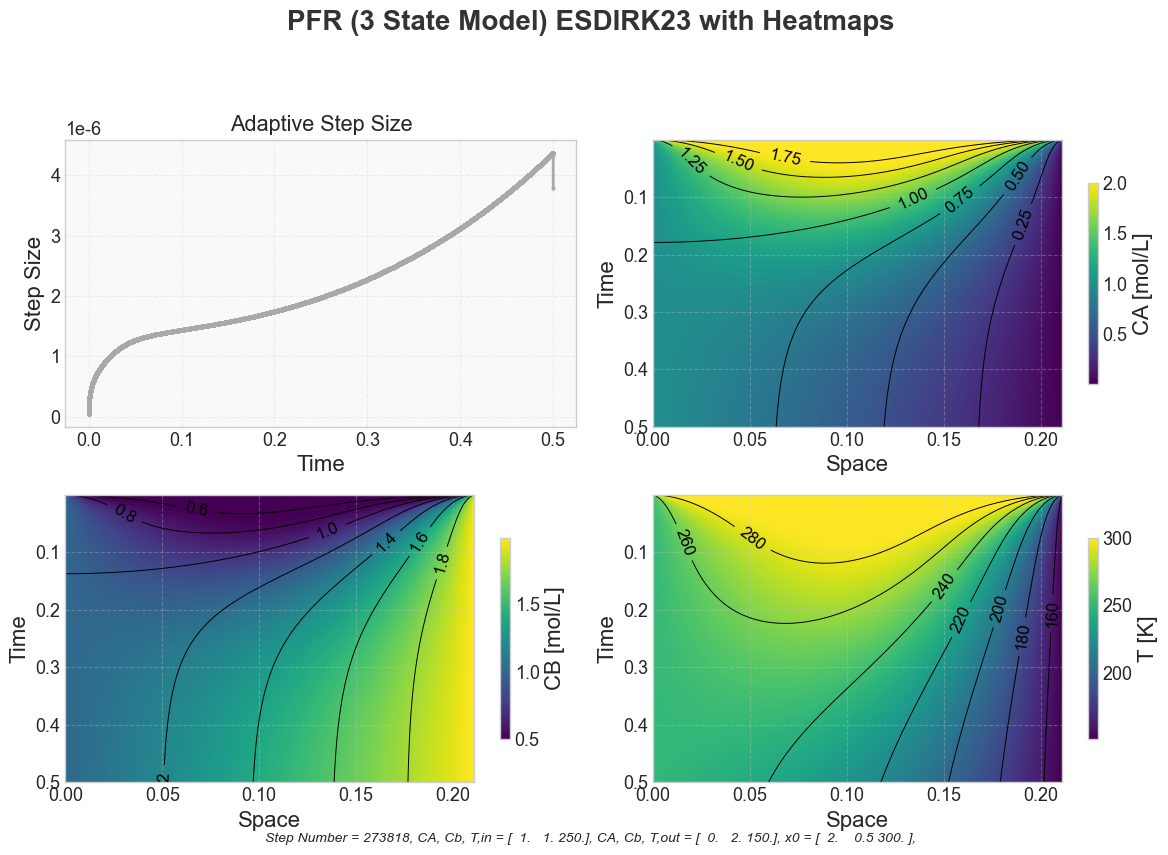

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

plt.style.use('seaborn-v0_8-whitegrid')

N = int(argv[9])  
dz = argv[10]     
L = (N + 1) * dz  
time_steps = t_history.shape[0]  

z = np.linspace(0, L, N)
t = t_history

Z, T = np.meshgrid(z, t)

def plot_heatmap_with_contours(data, title, cmap='viridis', ax=None):
    im = ax.imshow(data, 
                   extent=[z[0], z[-1], t[-1], t[0]], 
                   cmap=cmap, 
                   aspect='auto', 
                   interpolation='nearest')
    plt.colorbar(im, ax=ax, label=title, shrink=0.7)
    cs = ax.contour(Z, T, data, colors='black', linewidths=0.7)
    ax.clabel(cs, inline=True, fontsize=12)
    ax.set_xlabel('Space')
    ax.set_ylabel('Time')
    #ax.set_title(f'{title}')
    ax.set_facecolor('#f9f9f9')
    ax.grid(True, which="both", ls="--", alpha=0.3)
    return ax

fig = plt.figure(figsize=(12, 8))
gs = GridSpec(2, 2, figure=fig)

pic1 = fig.add_subplot(gs[0, 0])  # stepsize 曲线
pic2 = fig.add_subplot(gs[0, 1])  # CA 热力图
pic3 = fig.add_subplot(gs[1, 0])  # CB 热力图
pic4 = fig.add_subplot(gs[1, 1])  # T 热力图

pic1.plot(t_adaptive, t_adaptive_size, '#A9A9A9', linewidth=2, marker='.', markersize=4, alpha=1, label='Cython (Pure C)')
pic1.set_xlabel('Time')
pic1.set_ylabel('Step Size')
pic1.set_title('Adaptive Step Size')
pic1.grid(True, which="both", ls="--", alpha=0.3)
pic1.set_facecolor('#f9f9f9')

plot_heatmap_with_contours(x_history_1, 'CA [mol/L]', cmap='viridis', ax=pic2)
plot_heatmap_with_contours(x_history_2, 'CB [mol/L]', cmap='viridis', ax=pic3)
plot_heatmap_with_contours(x_history_3, 'T [K]', cmap='viridis', ax=pic4)

fig.suptitle('PFR (3 State Model) ESDIRK23 with Heatmaps', fontsize=20, fontweight='bold', color='#333333', y=1.05)
fig.text(0.5, 0.01, f'Step Number = {t_history.shape[0]}, CA, Cb, T,in = {argv[11:14]}, CA, Cb, T,out = {argv[14:17]}, x0 = {x0},', ha='center', fontsize=10, style='italic')

plt.tight_layout()
plt.savefig("ESDIRK23_PFR3.png")
plt.show()
